In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import random

from fine_tuning.pretrained_models.bisonai.models import OmniglotModelBisonai

In [3]:
### Parameters

num_classes = 3
learning_rate = 0.001
epochs = 5
checkpoint_path = "fine_tuning/pretrained_models/bisonai/1shot_3way_bisonai_ckpt_o15t/model.ckpt-99999"

def softmax(x):
    e = np.exp(x)
    return (e / np.sum(e, axis=1, keepdims=True))

## Data for fine-tuning & prediction

In [4]:
sess = tf.Session()

mnist_train = tfds.load(name="mnist", split=tfds.Split.TRAIN).batch(2000)
mnist_example = mnist_train.take(1)
mnist_example_iter = mnist_example.make_initializable_iterator()
sess.run(mnist_example_iter.initializer)

data = mnist_example_iter.get_next()
image = data['image']
label = data['label']
x, y = sess.run([image,label])

X_train = np.array(1-x[:num_classes,:,:,:]/255.0).reshape(3, 28, 28, 1)
y_train = np.array(y[:num_classes])

print(X_train.shape)
print(y_train.shape)

(3, 28, 28, 1)
(3,)


In [5]:
y_train

array([9, 0, 8])

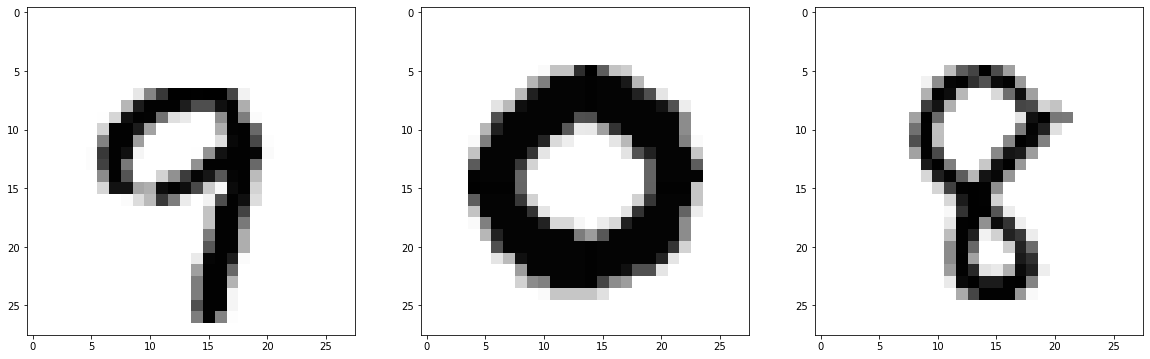

In [6]:
### Showing Images of the 3 classes after reshape 28x28x1

plt.figure(figsize=(20,20))
plt.subplot(131)
imgplot = plt.imshow(X_train[0,:,:,0], cmap="gist_gray")
plt.subplot(132)
imgplot = plt.imshow(X_train[1,:,:,0], cmap="gist_gray")
plt.subplot(133)
imgplot = plt.imshow(X_train[2,:,:,0], cmap="gist_gray")

In [7]:
res = sum([np.where(y == c)[0].tolist() for c in y_train], [])
[res.remove(i) for i in range(num_classes)]

ind = random.choice(res)
X_predict = np.array(1-x[ind,:,:,0]/255.0).reshape((1, 28, 28,1))
y_predict = y[ind]

print(X_predict.shape)

(1, 28, 28, 1)


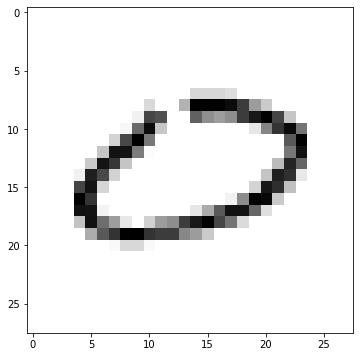

In [8]:
###### Showing the image with class to predict

plt.figure(figsize=(6,6))
imgplot = plt.imshow(X_predict[0,:,:,0], cmap="gist_gray")

## Preparing the model & prediction

In [9]:
model = OmniglotModelBisonai(num_classes=3, **{'learning_rate':learning_rate})
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

for i in tf.all_variables():
    if "Adam_1" in i.name:
        sess.run(tf.assign(i,i/(tf.sqrt(i) + 1e-5)))

In [10]:
y_train_label = np.array([0, 1, 2])

adam_var = [i for i in tf.all_variables() if "Adam_1" in i.name]

for e in range(epochs):
    grad_temp, logits, loss, _ = sess.run([tf.gradients(model.loss, tf.trainable_variables()), model.logits, model.loss, tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)], feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
    #print(grad_temp)
    print("softmax", softmax(logits))
    print("loss", np.sum(loss))
    for i,j,k in zip(tf.trainable_variables(), grad_temp, adam_var):
        sess.run(tf.assign(i,i-j*k*learning_rate))
        #print(sess.run(j*k*learning_rate))
    
    logits = sess.run(model.logits, feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})
    print("test softmax", softmax(logits))
result, logits = sess.run([model.predictions, model.logits], feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})

print("The result is {}.".format(y_train[result[0]]))
print("The probability distribution is {}.".format(softmax(logits)))

softmax [[0.26369599 0.33228844 0.4040156 ]
 [0.3272458  0.30374083 0.36901334]
 [0.3244182  0.33993706 0.3356448 ]]
loss 3.6162405
test softmax [[0.1745147  0.60386    0.22162524]]
softmax [[9.9308097e-01 3.2547930e-06 6.9157165e-03]
 [1.4965745e-10 1.0000000e+00 1.2664837e-09]
 [4.1042344e-04 2.6303879e-09 9.9958956e-01]]
loss 0.007353382
test softmax [[0.17385891 0.6043238  0.22181728]]
softmax [[9.9464965e-01 3.0111014e-06 5.3473776e-03]
 [1.4802001e-10 1.0000000e+00 1.3641439e-09]
 [4.0675496e-04 2.6034643e-09 9.9959326e-01]]
loss 0.005771563
test softmax [[0.173278  0.6046543 0.2220677]]
softmax [[9.9562430e-01 2.8292438e-06 4.3728449e-03]
 [1.4679459e-10 1.0000000e+00 1.4464141e-09]
 [4.0340607e-04 2.5841873e-09 9.9959660e-01]]
loss 0.0047887014
test softmax [[0.17275183 0.6049029  0.22234532]]
softmax [[9.9622053e-01 2.7250323e-06 3.7767189e-03]
 [1.4586003e-10 1.0000000e+00 1.5178655e-09]
 [4.0039280e-04 2.5681055e-09 9.9959964e-01]]
loss 0.00418712
test softmax [[0.17217343 0